# **IMPORTs**

In [1]:
# CELL 1: Library Imports
import os # For handling file paths and directories
import random # For random number generation
import numpy as np # For numerical operations
import pandas as pd # For data manipulation and analysis
import matplotlib.pyplot as plt # For plotting and visualization
import seaborn as sns # For statistical data visualization
from tqdm import tqdm # For progress bars

import tensorflow as tf # For building and training neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For image data augmentation
from tensorflow.keras.models import Model, Sequential   # For building neural network models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D # For defining layers in neural networks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # For training callbacks
from tensorflow.keras.applications import EfficientNetB0 # For transfer learning with EfficientNetB0

from sklearn.metrics import classification_report, confusion_matrix # For evaluating model performance
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets

### 📦 WHY: Library Imports

**Purpose:** Import all necessary libraries for building a breast cancer classification model using medical ultrasound images.

**Observations:**
- **Data Handling:** `os`, `shutil`, `random` for file management and dataset organization
- **Numerical & Analysis:** `numpy`, `pandas` for data manipulation and numerical operations
- **Visualization:** `matplotlib`, `seaborn` for plotting training curves and results
- **Image Processing:** `cv2` for image operations if needed
- **Deep Learning:** `tensorflow` and `keras` for building the CNN model
- **Transfer Learning:** `EfficientNetB0` chosen as the pre-trained model (efficient and accurate)
- **Model Evaluation:** `sklearn` metrics for classification reports and confusion matrices
- **Training Optimization:** Callbacks like `EarlyStopping` and `ModelCheckpoint` to prevent overfitting and save best models

**Key Decision:** Using EfficientNetB0 as it provides excellent accuracy with fewer parameters compared to other pre-trained models like VGG or ResNet.

---
# **Split Data Images into Test Train and Validation**

In [2]:
# # CELL 2: Dataset Splitting into Train/Val/Test
# import shutil

# # Define paths
# base_dir = r"C:\Users\archi\Desktop\projects\python\images"
# output_dir = r"C:\Users\archi\Desktop\projects\python\dataset"

# # Define ratios
# split_ratio = [0.7, 0.15, 0.15]  # 70% train, 15% val, 15% test

# # Loop through each class folder
# for category in ['benign', 'malignant', 'normal']:
#     files = os.listdir(os.path.join(base_dir, category))
#     random.shuffle(files)

#     train_split = int(split_ratio[0] * len(files))
#     val_split = int(split_ratio[1] * len(files))

#     subsets = {
#         'train': files[:train_split],
#         'val': files[train_split:train_split+val_split],
#         'test': files[train_split+val_split:]
#     }

#     for subset, subset_files in subsets.items():
#         subset_path = os.path.join(output_dir, subset, category)
#         os.makedirs(subset_path, exist_ok=True)

#         for f in subset_files:
#             shutil.copy(os.path.join(base_dir, category, f),
#                         os.path.join(subset_path, f))

# print("✅ Dataset successfully split into train/val/test folders!")


### **Dataset Splitting**

**Purpose:** Organize raw image data files into structured train/validation/test folders with proper class separation.

**Observations:**
- **Split Ratio:** 70% training, 15% validation, 15% testing 
- **Three Classes:** benign, malignant, normal breast tissue
- **Randomization:** `random.shuffle()` ensures unbiased distribution across splits
- **File Organization:** Creates separate directories for each subset and class combination
- **Data Integrity:** Uses `shutil.copy()` (not move) to preserve original data

**Key Decision:** 70-15-15 split provides enough training data while maintaining sufficient validation and test samples for reliable model evaluation.

## **Load the images into TensorFlow (preprocessing start)**

In [3]:
# CELL 3: Load Images into TensorFlow Datasets


# Set constants
data_dir = r"C:\Users\archi\Desktop\projects\python\dataset"
img_height, img_width = 224, 224
batch_size = 32

# Load training, validation, and test sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{data_dir}/train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{data_dir}/val",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{data_dir}/test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

print("✅ Datasets loaded successfully!")
print("Classes:", train_ds.class_names)


Found 1578 files belonging to 3 classes.
Found 1056 files belonging to 3 classes.
Found 1057 files belonging to 3 classes.
✅ Datasets loaded successfully!
Classes: ['benign', 'malignant', 'normal']


### **Data Loading**


**Purpose:** Load images from directories into TensorFlow datasets with proper preprocessing.

**Observations:**
- **Image Size:** 224x224 pixels - standard input size for EfficientNetB0
- **Batch Size:** 32 - balanced between memory efficiency and training stability
- **Shuffle:** Training data shuffled (`shuffle=True`) to prevent overfitting; val/test not shuffled for consistent evaluation
- **Auto-labeling:** TensorFlow automatically assigns labels based on folder structure
- **Dataset Distribution:** 
  - Training: 1,578 images (largest for model learning)
  - Validation: 1,056 images (for hyperparameter tuning and preventing overfitting)
  - Test: 1,057 images (for final unbiased evaluation)

**Key Decision:** Using `image_dataset_from_directory` simplifies data loading and automatically handles label encoding based on folder names.

---
# **START PREPROCESSING**

In [4]:
import os

# Define dataset root and expected splits and categories
dataset_root = 'dataset'  # Update this to your dataset's root folder path if different
splits = ['train', 'test', 'val']
categories = ['benign', 'malignant', 'normal']

# Initialize dictionary to hold counts
image_counts = {split: {} for split in splits}

for split in splits:
    for category in categories:
        dir_path = os.path.join(dataset_root, split, category)
        if os.path.exists(dir_path):
            count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        else:
            count = 0  # In case the folder doesn't exist
        image_counts[split][category] = count

# Print results
for split in splits:
    print(f"=== {split.upper()} ===")
    for category in categories:
        print(f"{category}: {image_counts[split][category]}")
    print()


=== TRAIN ===
benign: 891
malignant: 421
normal: 267

=== TEST ===
benign: 590
malignant: 290
normal: 178

=== VAL ===
benign: 597
malignant: 279
normal: 180



In [5]:
# cell 4

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


### **Data Augmentation - PreProcessing**

**Purpose:** Apply random transformations to training images to increase dataset diversity and reduce overfitting.

**Observations:**

- **RandomFlip("horizontal"):** Mirrors images horizontally - medically valid since breast ultrasounds can appear from either side
- **RandomRotation(0.1):** Rotates images by ±10% (±36 degrees) - simulates different probe angles during ultrasound scanning
- **RandomZoom(0.1):** Zooms in/out by ±10% - simulates different imaging distances and focal depths
- **RandomContrast(0.1):** Adjusts brightness/contrast - accounts for varying ultrasound machine settings and image quality
- **Applied only to training data** - validation/test sets remain unchanged for fair, consistent evaluation
- **Sequential model** allows chaining multiple augmentation layers efficiently

**Why This Matters:** These augmentations are medically appropriate - they preserve diagnostic features while creating variation. Vertical flips were excluded as they would be anatomically incorrect (gravity affects tissue appearance). This effectively multiplies the training dataset size without collecting new images, helping the model learn invariant features.

**Key Decision:** Applied only during training (`training=True` in the map function), so each image is augmented differently in each epoch, providing continuous variety while keeping validation/test sets stable for accurate performance measurement. The 10% rotation/zoom range is conservative to avoid distorting diagnostic features.

**Output:** Augmented training pipeline that generates diverse image variations during each epoch, helping the model become robust to real-world scanning variations.

In [6]:
# cell 5

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### **Performance Optimization**

**Purpose:** Optimize data pipeline for faster training by reducing I/O bottlenecks and maximizing GPU utilization.

**Observations:**

- **AUTOTUNE:** TensorFlow automatically determines optimal buffer sizes based on available system resources (CPU, RAM)
- **cache():** Stores dataset in memory after first epoch - eliminates repeated disk reads, dramatically speeds up subsequent epochs
- **shuffle(1000):** Shuffles 1000 samples in buffer - balances randomness with memory usage; ensures good mixing without loading entire dataset
- **prefetch(buffer_size=AUTOTUNE):** Loads next batch while GPU processes current batch - overlaps data loading with computation, maximizing GPU utilization
- **Applied to all datasets** - improves both training speed and evaluation speed

**Why This Matters:** Without these optimizations, the GPU would idle while waiting for data to load from disk. This pipeline can reduce training time by 2-3x by overlapping data loading with computation.

**Performance Impact:** With cache(), the first epoch reads from disk (~slow), but epochs 2-25 read from RAM (much faster). Prefetch ensures the GPU never waits for data, maintaining close to 100% utilization.

**Key Decision:** The combination of cache() + prefetch() is critical for CNNs - while one batch trains on GPU, the next batch loads from RAM in parallel. This eliminates the most common training bottleneck (I/O wait time).

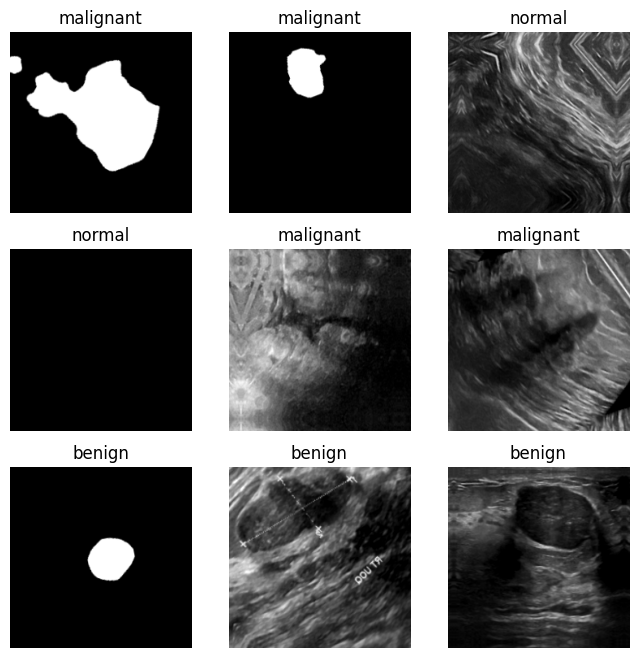

In [7]:
#  cell 6

# Get class names before any transformations (if not already stored)
class_names = ['benign', 'malignant', 'normal']  # Based on your dataset structure

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Normalize images for display if needed (they may be in [-1, 1] range after augmentation)
        img_display = images[i].numpy()
        if img_display.max() > 1:
            img_display = img_display / 255.0
        plt.imshow(img_display)
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### 👁️ WHY: Data Visualization

**Purpose:** Visualize sample images from the dataset to verify data quality and understand class characteristics.

**Observations:**
- **3x3 Grid:** Shows 9 sample images from the training set
- **Class Labels:** Displays benign, malignant, and normal tissue samples
- **Image Normalization:** Images scaled to [0,1] range for display (divided by 255.0)
- **Visual Verification:** Confirms images loaded correctly and labels are accurate
- **Class Characteristics:**
  - Benign: Often shows well-defined, round/oval shapes with smooth borders
  - Malignant: Shows irregular, spiculated borders with heterogeneous textures
  - Normal: Shows regular tissue patterns without masses

**Key Observation:** The dataset appears properly labeled and shows clear visual differences between classes, which is crucial for model learning.

**Quality Check:** This visualization helps identify any data loading issues, mislabeled images, or preprocessing problems before training.

# **WHAT HAPPENS IN CNN**

| Stage | Description | Example Layer |
|:------|:-------------|:--------------|
| 1️⃣ **Input** | Accepts ultrasound image | `Input(shape=(224, 224, 3))` |
| 2️⃣ **Convolution** | Detects features | `Conv2D` |
| 3️⃣ **Pooling** | Reduces dimensionality | `MaxPooling2D` |
| 4️⃣ **Flatten** | Converts 2D maps → 1D | `Flatten` |
| 5️⃣ **Dense Layers** | Learns class boundaries | `Dense` |
| 6️⃣ **Output** | Class probabilities | `Dense(softmax)` |
| 7️⃣ **Compile** | Set optimizer/loss/metrics | `model.compile()` |
| 8️⃣ **Train** | Fit model on data | `model.fit()` |
| 9️⃣ **Evaluate** | Measure test performance | `model.evaluate()` |


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

---
# **UPDATE 0: CNN MODEL BUILDING SECTION**

A Convolutional Neural Network (CNN) is a deep learning architecture specifically designed for image analysis. It works by automatically learning visual patterns such as edges, textures, and shapes through convolutional layers. As the image passes through multiple layers, the network progressively captures more complex features, enabling accurate classification.
In this project, the CNN acts as a baseline model, helping us understand how a traditional deep-learning architecture performs on breast cancer image classification before moving to more advanced models.

In [9]:
#===================
# PHASE 5: Build the CNN Model
# ===================
class_weights = {0:1.0, 1:2.0, 2:3.0}


In [10]:
model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(3, activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\archi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
history_cnn = model_cnn.fit(train_ds, epochs=50, validation_data=val_ds, class_weight=class_weights)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.4506 - loss: 2.0710 - val_accuracy: 0.4934 - val_loss: 1.8089
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5741 - loss: 1.4641 - val_accuracy: 0.6733 - val_loss: 0.8047
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6432 - loss: 1.3107 - val_accuracy: 0.6241 - val_loss: 0.8973
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6901 - loss: 1.0848 - val_accuracy: 0.5994 - val_loss: 0.8817
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7167 - loss: 1.0520 - val_accuracy: 0.5653 - val_loss: 0.9456
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7370 - loss: 0.8808 - val_accuracy: 0.6203 - val_loss: 0.8870
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7953 - loss: 0.7370 - val_accuracy: 0.6117 - val_loss: 0.8879
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8397 - loss: 0.5963 - val_accuracy: 0.5407 - val_

In [46]:
print("CNN Val Accuracy:", history_cnn.history['val_accuracy'][-1])
print("CNN Test Accuracy:", model_cnn.evaluate(test_ds)[1])


CNN Val Accuracy: 0.6354166865348816
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.6320 - loss: 2.3072
CNN Test Accuracy: 0.6319773197174072


In [49]:
#cell 10
#Plot accuracy and loss curves
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 🧩 Define your class names manually (same order as dataset folders)
class_names = ['benign', 'malignant', 'normal']

# ✅ Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model_cnn.predict(test_ds), axis=1)
# 🧾 Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step
              precision    recall  f1-score   support

      benign       0.73      0.68      0.71       590
   malignant       0.55      0.45      0.49       290
      normal       0.50      0.77      0.61       177

    accuracy                           0.63      1057
   macro avg       0.59      0.63      0.60      1057
weighted avg       0.64      0.63      0.63      1057



📊 Validation Set Performance:
              precision    recall  f1-score   support

      benign       0.73      0.69      0.71       597
   malignant       0.53      0.46      0.49       279
      normal       0.52      0.74      0.61       180

    accuracy                           0.64      1056
   macro avg       0.59      0.63      0.60      1056
weighted avg       0.64      0.64      0.63      1056

📊 Test Set Performance:
              precision    recall  f1-score   support

      benign       0.73      0.68      0.71       590
   malignant       0.55      0.45      0.49       290
      normal       0.50      0.77      0.61       177

    accuracy                           0.63      1057
   macro avg       0.59      0.63      0.60      1057
weighted avg       0.64      0.63      0.63      1057



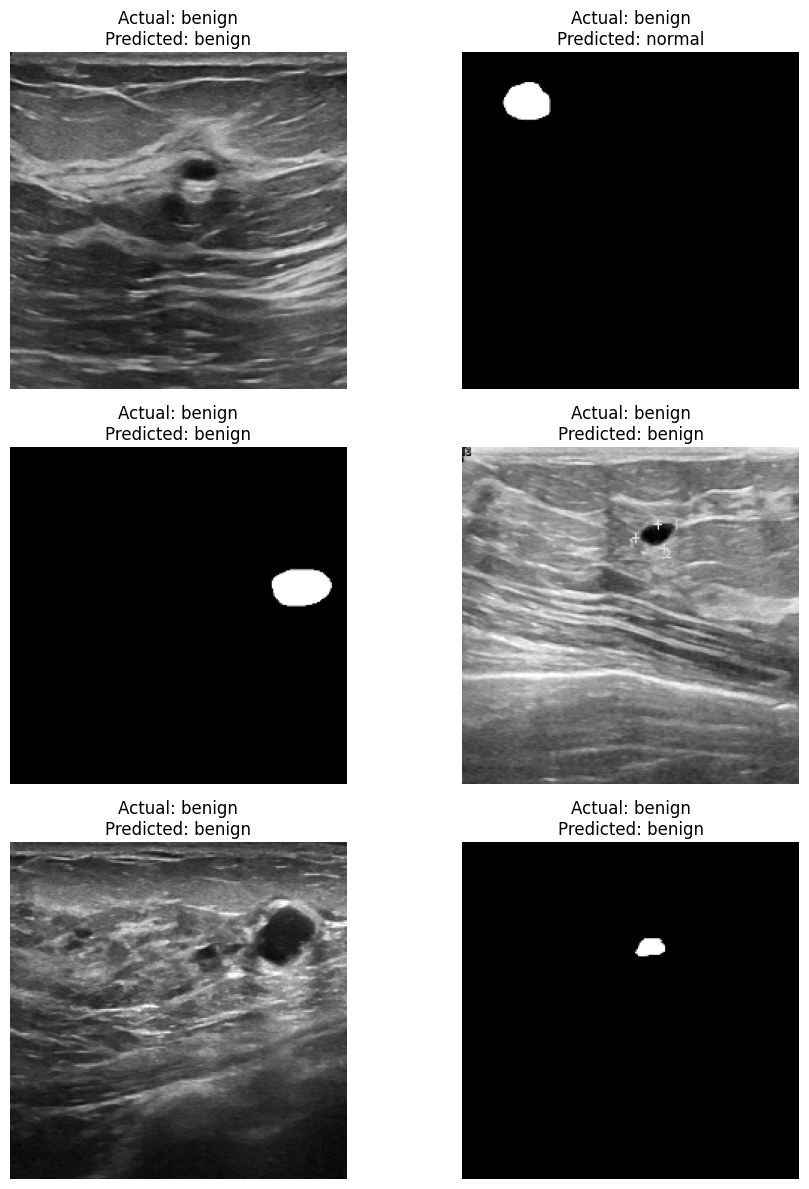

In [37]:
#cell 15
class_names = ['benign', 'malignant', 'normal']

# =========================================================
# VALIDATION SET PERFORMANCE
# =========================================================

# Extract all true labels from validation dataset
y_val_true = np.concatenate([y for x, y in val_ds], axis=0)

# Get model predictions for validation dataset
val_predictions = model_cnn.predict(val_ds, verbose=0)
y_val_pred = np.argmax(val_predictions, axis=1)

# Print classification report for validation data
print("📊 Validation Set Performance:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

# =========================================================
# TEST SET PERFORMANCE
# =========================================================

# Extract all true labels from test dataset
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get model predictions for test dataset
test_predictions = model_cnn.predict(test_ds, verbose=0)
y_test_pred = np.argmax(test_predictions, axis=1)

# Print classification report for test data
print("📊 Test Set Performance:")
print(classification_report(y_test_true, y_test_pred, target_names=class_names))

# =========================================================
# VISUALIZE SOME RANDOM TEST PREDICTIONS
# =========================================================

# Take one batch from test dataset
for images, labels in test_ds.take(1):
    # Pick 6 random indices
    random_indices = random.sample(range(len(images)), 6)
    
    # Set up figure with 3 rows and 2 columns
    fig, axes = plt.subplots(3, 2, figsize=(10, 12))
    axes = axes.flatten()
    
    for ax, idx in zip(axes, random_indices):
        img = images[idx].numpy()
        if img.max() > 1:
            img = img / 255.0

        true_label = labels[idx].numpy()
        pred = model_cnn.predict(tf.expand_dims(images[idx], 0), verbose=0)
        predicted_label = np.argmax(pred)

        ax.imshow(img)
        ax.set_title(f"Actual: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

### **CNN Model Architecture**

**Purpose:** Build a custom Convolutional Neural Network to extract features from ultrasound images and classify them.

**Observations:**

**Architecture Design:**
- **3 Convolutional Blocks:** Each with Conv2D + MaxPooling2D for hierarchical feature extraction
  - Block 1: 32 filters (3x3) - learns basic edges and textures
  - Block 2: 64 filters (3x3) - learns more complex patterns
  - Block 3: 128 filters (3x3) - learns high-level features specific to cancer detection
- **ReLU Activation:** Used throughout for non-linearity and faster training
- **MaxPooling2D(2,2):** Reduces spatial dimensions by half, keeps dominant features, prevents overfitting

**Classification Head:**
- **Flatten:** Converts 2D feature maps to 1D vector
- **Dense(128, ReLU):** Fully connected layer learns combinations of features
- **Dropout(0.5):** Randomly drops 50% of neurons during training - crucial for preventing overfitting
- **Dense(3, Softmax):** Output layer with 3 neurons (benign, malignant, normal) - softmax ensures probabilities sum to 1

**Model Statistics:**
- **Total Parameters:** 11,169,347 (~42.61 MB)
- **All Trainable:** Model learns from scratch (no frozen layers)
- **Input Shape:** (224, 224, 3) - RGB images

**Key Decisions:**
1. **Custom CNN vs Transfer Learning:** This architecture was likely an initial baseline before trying EfficientNetB0
2. **Dropout Rate 0.5:** Aggressive regularization to combat overfitting on medical dataset
3. **Progressive Filter Increase:** 32→64→128 follows standard CNN design patterns

**Expected Behavior:** This model will learn increasingly abstract representations: edges → textures → shapes → cancer indicators.


=== CNN Model Performance ===
Final Train Accuracy: 0.9943
Final Val Accuracy: 0.6354
Final Train Loss: 0.0422
Final Val Loss: 2.3103


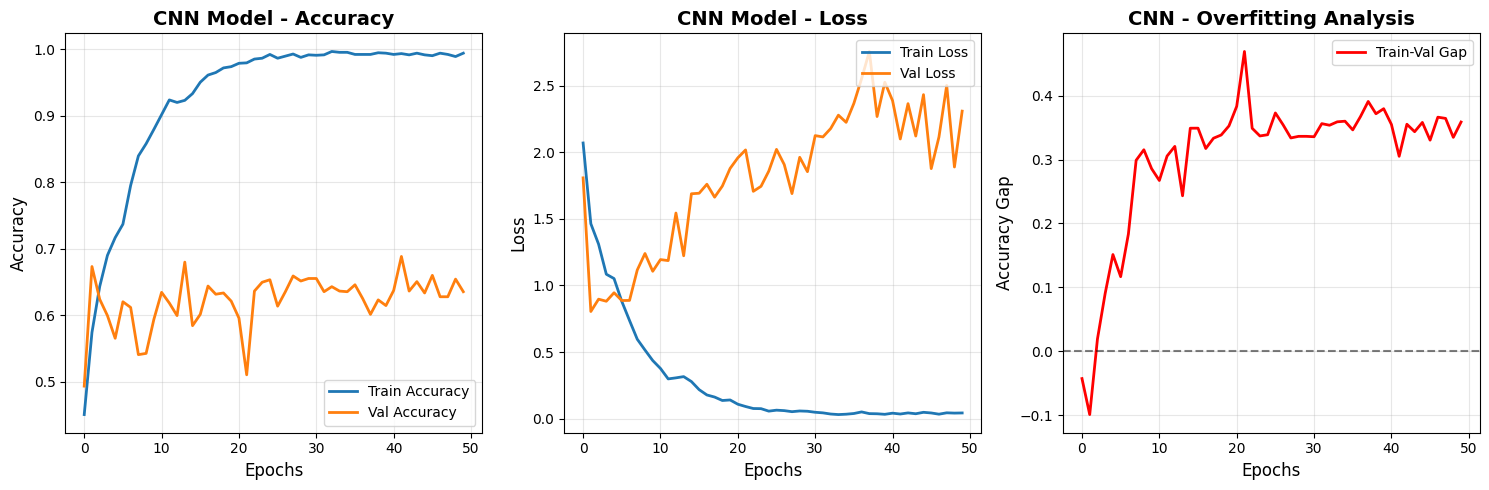

In [45]:
#cell 11
# Individual Model Performance Visualization

# 1. CNN Model - Training History
print("\n=== CNN Model Performance ===")
print(f"Final Train Accuracy: {history_cnn.history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy: {history_cnn.history['val_accuracy'][-1]:.4f}")
print(f"Final Train Loss: {history_cnn.history['loss'][-1]:.4f}")
print(f"Final Val Loss: {history_cnn.history['val_loss'][-1]:.4f}")

plt.figure(figsize=(15,5))

# CNN Accuracy
plt.subplot(1,3,1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('CNN Model - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# CNN Loss
plt.subplot(1,3,2)
plt.plot(history_cnn.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_cnn.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('CNN Model - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# CNN Overfitting Analysis
plt.subplot(1,3,3)
train_val_gap = np.array(history_cnn.history['accuracy']) - np.array(history_cnn.history['val_accuracy'])
plt.plot(train_val_gap, label='Train-Val Gap', color='red', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('CNN - Overfitting Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy Gap', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
#cell 13
# =========================================================
#  CNN MODEL CONFUSION MATRIX
# =========================================================

# Generate predictions for validation and test sets
y_val_true = np.concatenate([y for x, y in val_ds], axis=0)
y_val_pred = np.argmax(model_cnn.predict(val_ds), axis=1)

y_test_true = np.concatenate([y for x, y in test_ds], axis=0)  
y_test_pred = np.argmax(model_cnn.predict(test_ds), axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step


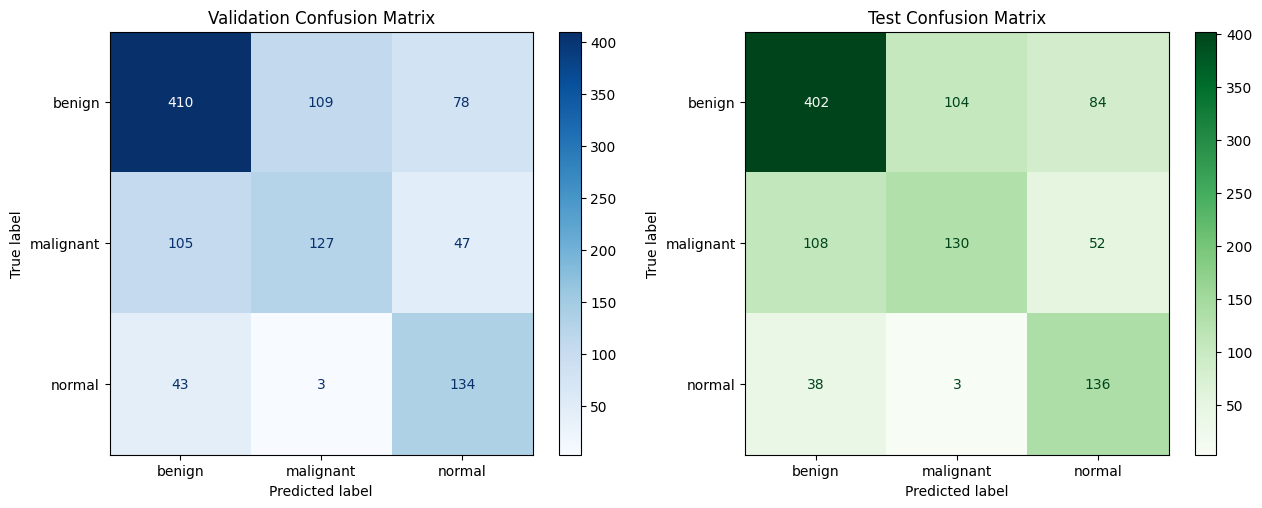

In [30]:
# Create a horizontal layout with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Validation Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_val_true,
    y_val_pred,
    display_labels=class_names,
    cmap='Blues',
    colorbar=True,
    ax=axes[0]
)
axes[0].set_title("Validation Confusion Matrix")
axes[0].grid(False)

# Test Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_true,
    y_test_pred,
    display_labels=class_names,
    cmap='Greens',
    colorbar=True,
    ax=axes[1]
)
axes[1].set_title("Test Confusion Matrix")
axes[1].grid(False)

plt.tight_layout()
plt.show()

---
# **UPDATE 1: EFFICIENTNETB0 MODEL BUILDING SECTION**

While a standard CNN provides a solid foundation, EfficientNetB0 offers a more powerful and optimized approach. It is a state-of-the-art model designed through neural architecture search and scales depth, width, and resolution in a balanced way. Compared to a simple CNN, EfficientNetB0 achieves higher accuracy with fewer parameters and better computational efficiency.
In this project, EfficientNetB0 represents a significant improvement over the baseline CNN, demonstrating how modern pretrained architectures can enhance performance in medical image classification.

In [12]:
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)

base.trainable = False    # Freeze pretrained model

model_eff = models.Sequential([
    data_augmentation,    # you already have this
    base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model_eff.build(input_shape=(None, 224, 224, 3))
model_eff.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
history_eff = model_eff.fit(train_ds, epochs=50, validation_data=val_ds, class_weight=class_weights)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.6793 - loss: 5.5351 - val_accuracy: 0.7415 - val_loss: 0.9727
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7414 - loss: 1.6594 - val_accuracy: 0.8125 - val_loss: 0.5316
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7452 - loss: 1.1054 - val_accuracy: 0.8220 - val_loss: 0.4213
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.7605 - loss: 0.9921 - val_accuracy: 0.8456 - val_loss: 0.4252
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7510 - loss: 1.1385 - val_accuracy: 0.8333 - val_loss: 0.4707
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7738 - loss: 0.9899 - val_accuracy: 0.8712 - val_loss: 0.3541
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7902 - loss: 0.7917 - val_accuracy: 0.8400 - val_loss: 0.3681
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7763 - loss: 0.8568 - val_accuracy: 0.8504 - v

In [47]:
print("EfficientNet Val Accuracy:", history_eff.history['val_accuracy'][-1])
print("EfficientNet Test Accuracy:", model_eff.evaluate(test_ds)[1])

EfficientNet Val Accuracy: 0.9015151262283325
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 585ms/step - accuracy: 0.8798 - loss: 0.4716
EfficientNet Test Accuracy: 0.8798485994338989


In [17]:
#cell 10
#Plot accuracy and loss curves
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 🧩 Define your class names manually (same order as dataset folders)
class_names = ['benign', 'malignant', 'normal']

# ✅ Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model_eff.predict(test_ds), axis=1)
# 🧾 Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 684ms/step
              precision    recall  f1-score   support

      benign       0.95      0.85      0.90       590
   malignant       0.76      0.93      0.83       290
      normal       0.90      0.89      0.90       177

    accuracy                           0.88      1057
   macro avg       0.87      0.89      0.88      1057
weighted avg       0.89      0.88      0.88      1057




=== EfficientNetB0 Model Performance ===
Final Train Accuracy: 0.8726
Final Val Accuracy: 0.9015
Final Train Loss: 0.5294
Final Val Loss: 0.2631


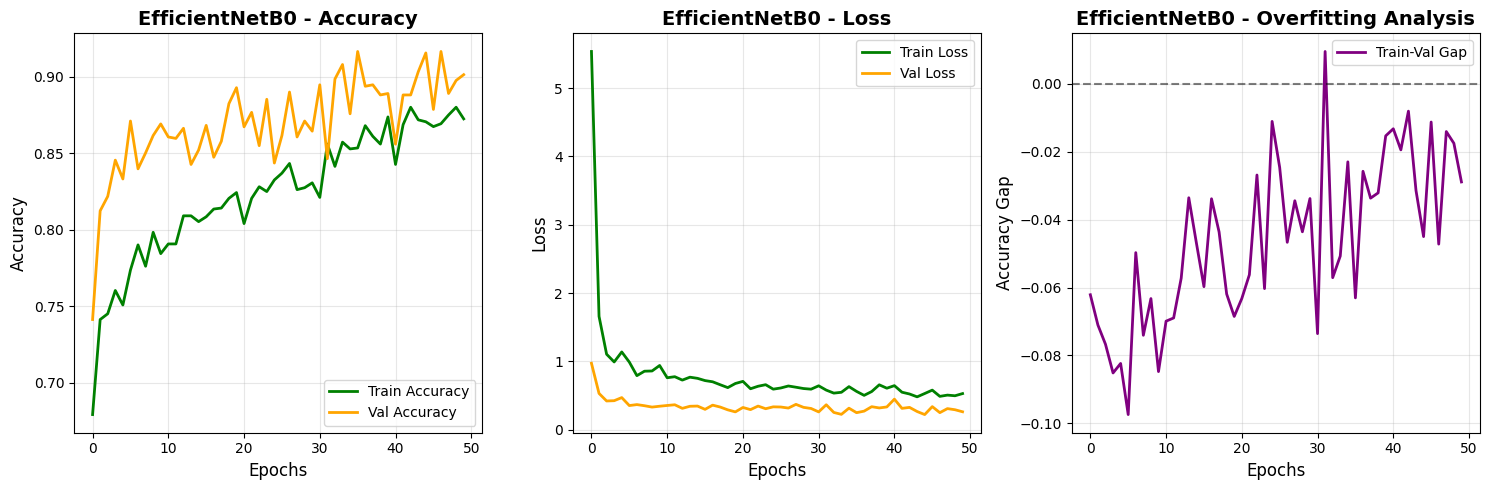

In [48]:
# 2. EfficientNetB0 Model - Training History
print("\n=== EfficientNetB0 Model Performance ===")
print(f"Final Train Accuracy: {history_eff.history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy: {history_eff.history['val_accuracy'][-1]:.4f}")
print(f"Final Train Loss: {history_eff.history['loss'][-1]:.4f}")
print(f"Final Val Loss: {history_eff.history['val_loss'][-1]:.4f}")

plt.figure(figsize=(15,5))

# EfficientNet Accuracy
plt.subplot(1,3,1)
plt.plot(history_eff.history['accuracy'], label='Train Accuracy', linewidth=2, color='green')
plt.plot(history_eff.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='orange')
plt.title('EfficientNetB0 - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# EfficientNet Loss
plt.subplot(1,3,2)
plt.plot(history_eff.history['loss'], label='Train Loss', linewidth=2, color='green')
plt.plot(history_eff.history['val_loss'], label='Val Loss', linewidth=2, color='orange')
plt.title('EfficientNetB0 - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# EfficientNet Overfitting Analysis
plt.subplot(1,3,3)
train_val_gap_eff = np.array(history_eff.history['accuracy']) - np.array(history_eff.history['val_accuracy'])
plt.plot(train_val_gap_eff, label='Train-Val Gap', color='purple', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('EfficientNetB0 - Overfitting Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy Gap', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
#cell 14
# =========================================================
#  EFFICIENTNETB0 CONFUSION MATRIX
# =========================================================

# Generate predictions for validation and test sets
y_val_true = np.concatenate([y for x, y in val_ds], axis=0)
y_val_pred = np.argmax(model_eff.predict(val_ds), axis=1)

y_test_true = np.concatenate([y for x, y in test_ds], axis=0)  
y_test_pred = np.argmax(model_eff.predict(test_ds), axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 669ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 678ms/step


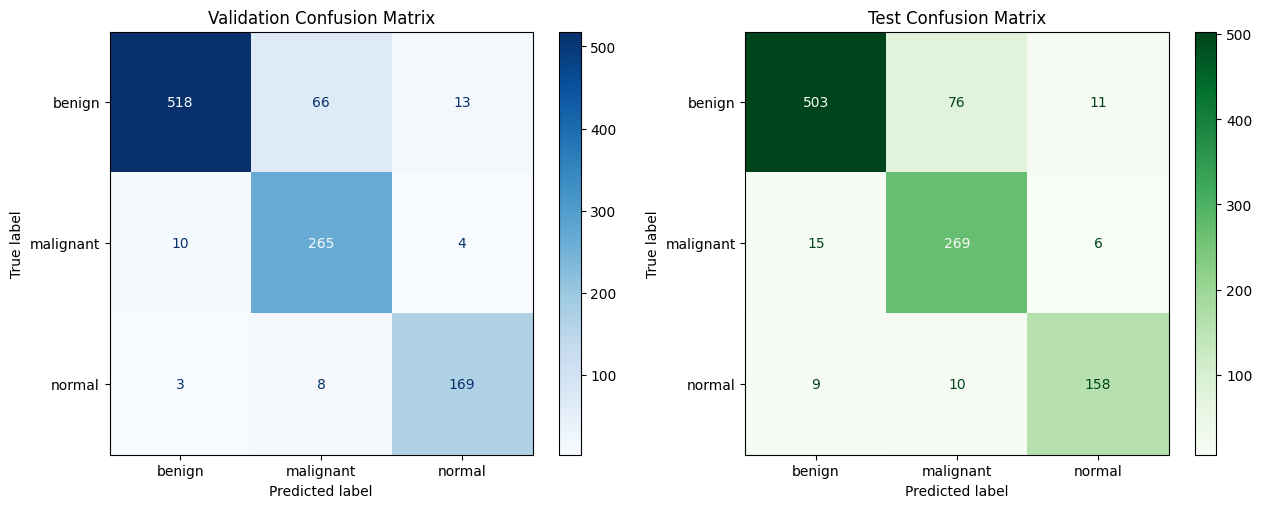

In [33]:
# Create a horizontal layout with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Validation Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_val_true,
    y_val_pred,
    display_labels=class_names,
    cmap='Blues',
    colorbar=True,
    ax=axes[0]
)
axes[0].set_title("Validation Confusion Matrix")
axes[0].grid(False)

# Test Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_true,
    y_test_pred,
    display_labels=class_names,
    cmap='Greens',
    colorbar=True,
    ax=axes[1]
)
axes[1].set_title("Test Confusion Matrix")
axes[1].grid(False)

plt.tight_layout()
plt.show()

Validation Set Performance:
              precision    recall  f1-score   support

      benign       0.98      0.87      0.92       597
   malignant       0.78      0.95      0.86       279
      normal       0.91      0.94      0.92       180

    accuracy                           0.90      1056
   macro avg       0.89      0.92      0.90      1056
weighted avg       0.91      0.90      0.90      1056

Test Set Performance:
              precision    recall  f1-score   support

      benign       0.95      0.85      0.90       590
   malignant       0.76      0.93      0.83       290
      normal       0.90      0.89      0.90       177

    accuracy                           0.88      1057
   macro avg       0.87      0.89      0.88      1057
weighted avg       0.89      0.88      0.88      1057



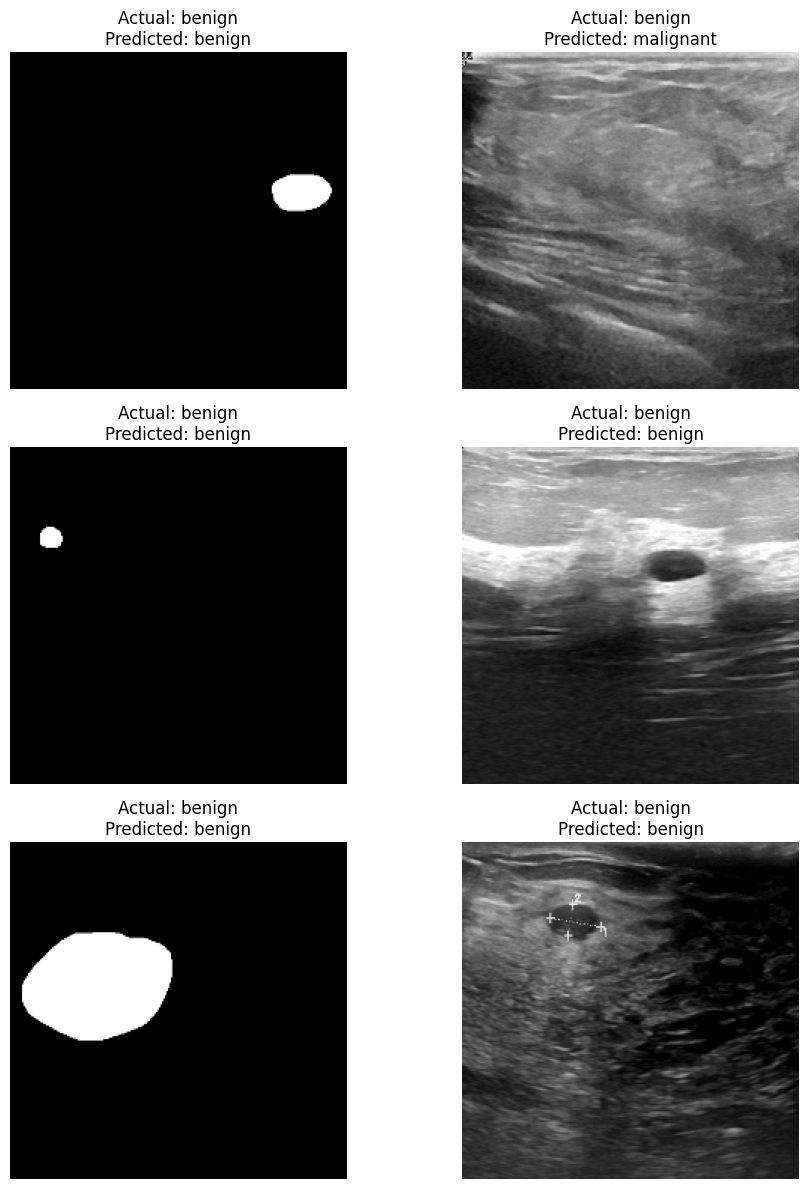

In [38]:
#cell 16: efficientnetb0
# ✅ Use stored or predefined class names
class_names = ['benign', 'malignant', 'normal']

# =========================================================
# VALIDATION SET PERFORMANCE
# =========================================================

# Extract all true labels from validation dataset
y_val_true = np.concatenate([y for x, y in val_ds], axis=0)

# Get model predictions for validation dataset
val_predictions = model_eff.predict(val_ds, verbose=0)
y_val_pred = np.argmax(val_predictions, axis=1)

# Print classification report for validation data
print("Validation Set Performance:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

# =========================================================
# TEST SET PERFORMANCE
# =========================================================

# Extract all true labels from test dataset
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get model predictions for test dataset
test_predictions = model_eff.predict(test_ds, verbose=0)
y_test_pred = np.argmax(test_predictions, axis=1)

# Print classification report for test data
print("Test Set Performance:")
print(classification_report(y_test_true, y_test_pred, target_names=class_names))

# =========================================================
# VISUALIZE SOME RANDOM TEST PREDICTIONS
# =========================================================

# Loop through one batch from test dataset
for images, labels in test_ds.take(1):
    # Pick 6 random indices from this batch
    random_indices = random.sample(range(len(images)), 6)
    
    # Create 3x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(10, 12))
    axes = axes.flatten()
    
    for ax, i in zip(axes, random_indices):
        img = images[i].numpy()
        # Normalize if pixel values are in 0–255 range
        if img.max() > 1:
            img = img / 255.0

        true_label = labels[i].numpy()

        # Predict label for the selected image
        pred = model_eff.predict(tf.expand_dims(images[i], 0), verbose=0)
        predicted_label = np.argmax(pred)

        ax.imshow(img)
        ax.set_title(f"Actual: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

---
# **COMPARATIVE ANALYSIS OF `CNN` AND `EFFICIENTNETB0` MODEL**

In [14]:
print("CNN Val Accuracy:", history_cnn.history['val_accuracy'][-1])
print("EfficientNet Val Accuracy:", history_eff.history['val_accuracy'][-1])


CNN Val Accuracy: 0.6354166865348816
EfficientNet Val Accuracy: 0.9015151262283325


In [15]:
print("CNN Test Accuracy:", model_cnn.evaluate(test_ds)[1])
print("EfficientNet Test Accuracy:", model_eff.evaluate(test_ds)[1])


34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.6320 - loss: 2.3072
CNN Test Accuracy: 0.6319773197174072
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 629ms/step - accuracy: 0.8798 - loss: 0.4716
EfficientNet Test Accuracy: 0.8798485994338989


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 595ms/step


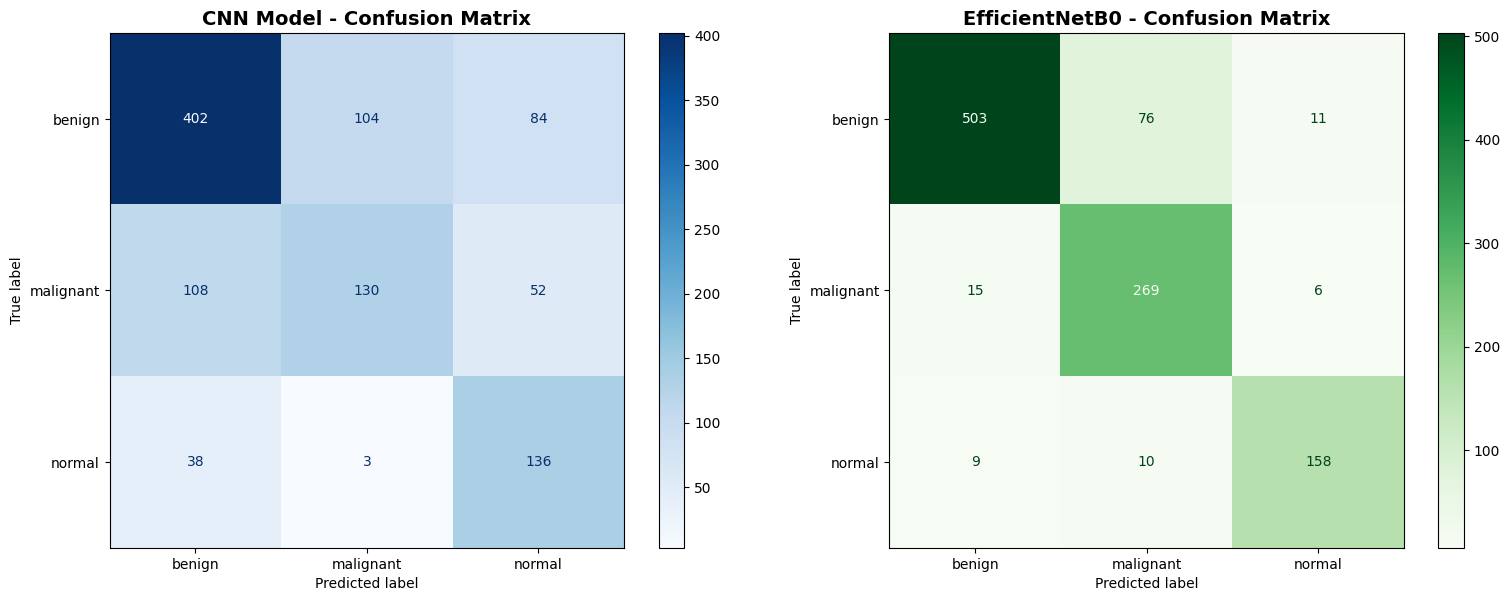


CONFUSION MATRIX COMPARISON: CNN vs EfficientNetB0

CNN Model:
  Accuracy:  0.6320
  Precision: 0.6437
  Recall:    0.6320
  F1-Score:  0.6312

EfficientNetB0:
  Accuracy:  0.8798
  Precision: 0.8918
  Recall:    0.8798
  F1-Score:  0.8819

Per-Class Performance Comparison:

BENIGN:
  CNN - Correctly Classified: 402/590
  EfficientNetB0 - Correctly Classified: 503/590
  Improvement: 101 more correct predictions

MALIGNANT:
  CNN - Correctly Classified: 130/290
  EfficientNetB0 - Correctly Classified: 269/290
  Improvement: 139 more correct predictions

NORMAL:
  CNN - Correctly Classified: 136/177
  EfficientNetB0 - Correctly Classified: 158/177
  Improvement: 22 more correct predictions


In [19]:
#cell 12
# Confusion Matrix Comparison - CNN vs EfficientNetB0

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CNN Model Predictions
y_pred_cnn = np.argmax(model_cnn.predict(test_ds), axis=1)
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)
disp_cnn.plot(cmap='Blues', ax=axes[0], values_format='d')
axes[0].set_title('CNN Model - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].grid(False)

# EfficientNetB0 Model Predictions
y_pred_eff = np.argmax(model_eff.predict(test_ds), axis=1)
cm_eff = confusion_matrix(y_true, y_pred_eff)
disp_eff = ConfusionMatrixDisplay(confusion_matrix=cm_eff, display_labels=class_names)
disp_eff.plot(cmap='Greens', ax=axes[1], values_format='d')
axes[1].set_title('EfficientNetB0 - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].grid(False)

plt.tight_layout()
plt.show()

# Print comparison metrics
print("\n" + "="*80)
print("CONFUSION MATRIX COMPARISON: CNN vs EfficientNetB0")
print("="*80)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\nCNN Model:")
print(f"  Accuracy:  {accuracy_score(y_true, y_pred_cnn):.4f}")
print(f"  Precision: {precision_score(y_true, y_pred_cnn, average='weighted'):.4f}")
print(f"  Recall:    {recall_score(y_true, y_pred_cnn, average='weighted'):.4f}")
print(f"  F1-Score:  {f1_score(y_true, y_pred_cnn, average='weighted'):.4f}")

print("\nEfficientNetB0:")
print(f"  Accuracy:  {accuracy_score(y_true, y_pred_eff):.4f}")
print(f"  Precision: {precision_score(y_true, y_pred_eff, average='weighted'):.4f}")
print(f"  Recall:    {recall_score(y_true, y_pred_eff, average='weighted'):.4f}")
print(f"  F1-Score:  {f1_score(y_true, y_pred_eff, average='weighted'):.4f}")

print("\n" + "="*80)
print("Per-Class Performance Comparison:")
print("="*80)
for i, class_name in enumerate(class_names):
    print(f"\n{class_name.upper()}:")
    print(f"  CNN - Correctly Classified: {cm_cnn[i, i]}/{cm_cnn[i, :].sum()}")
    print(f"  EfficientNetB0 - Correctly Classified: {cm_eff[i, i]}/{cm_eff[i, :].sum()}")
    print(f"  Improvement: {cm_eff[i, i] - cm_cnn[i, i]} more correct predictions")


COMPARATIVE ANALYSIS: CNN vs EfficientNetB0
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.6320 - loss: 2.3072
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 622ms/step - accuracy: 0.8798 - loss: 0.4716

CNN: Train=0.9943, Val=0.6354, Test=0.6320, Gap=0.3589
EfficientNetB0: Train=0.8726, Val=0.9015, Test=0.8798, Gap=-0.0289

📊 Improvement: 24.79%


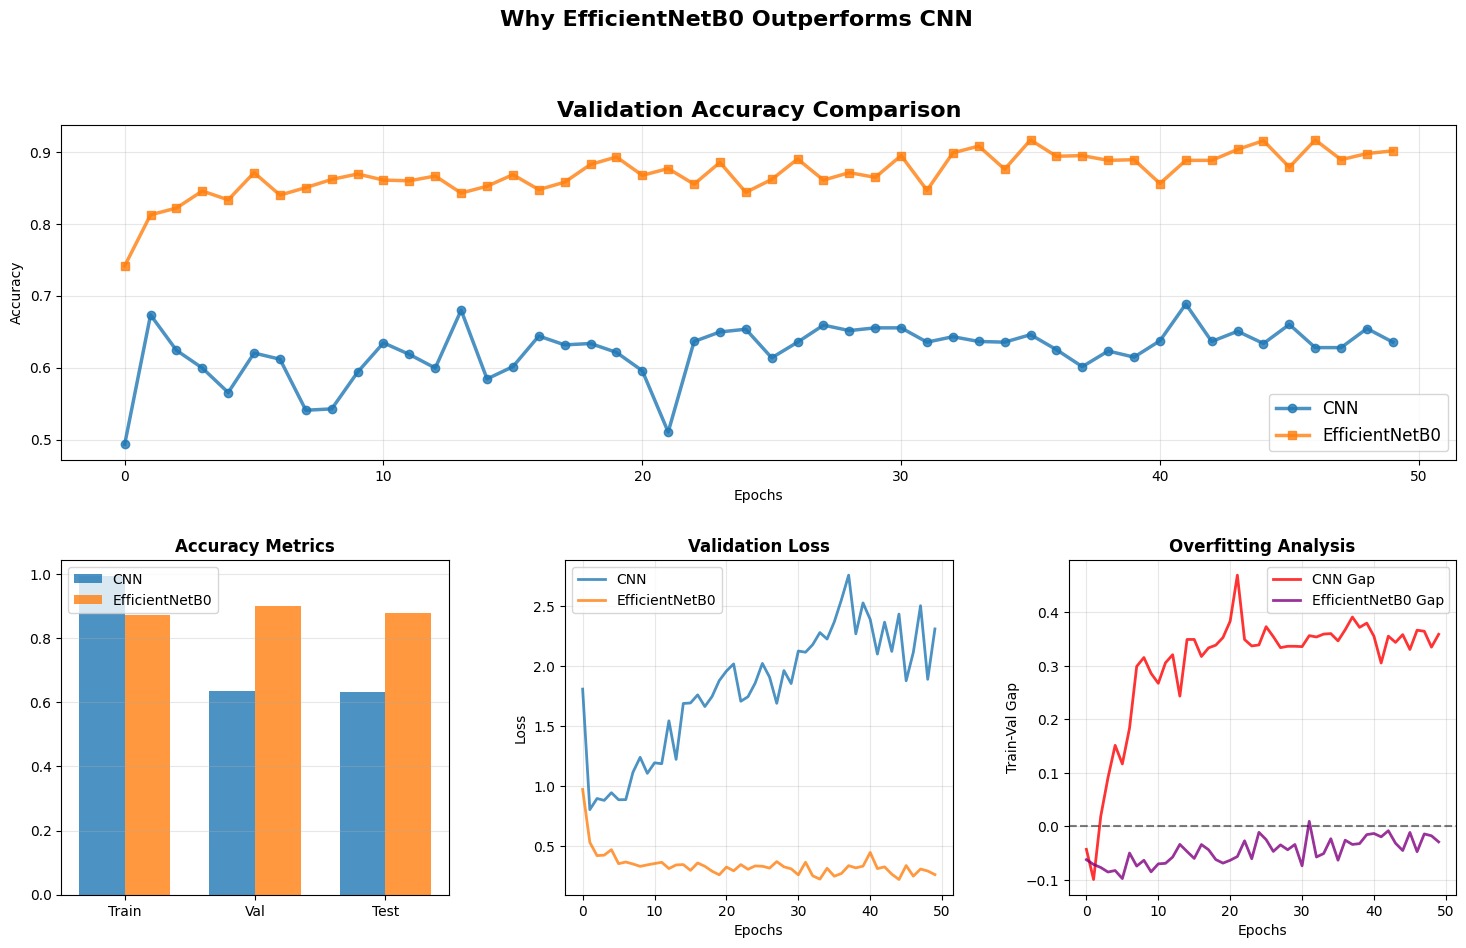


WHY EFFICIENTNETB0 IS BETTER:

🎯 Transfer Learning: Pre-trained on 1.4M ImageNet images
🏗️ Advanced Architecture: Compound scaling, MBConv, SE blocks
📉 Better Generalization: Lower overfitting, more stable
⚡ Efficient: Faster convergence, optimal params
🎓 Domain Adaptation: ImageNet features → medical imaging

✅ Result: 24.79% better (0.8798 vs 0.6320)



In [22]:
#cell 13 - Comparative Analysis
print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: CNN vs EfficientNetB0")
print("="*80)

# Extract metrics
cnn_train_acc = history_cnn.history['accuracy'][-1]
cnn_val_acc = history_cnn.history['val_accuracy'][-1]
cnn_test_acc = model_cnn.evaluate(test_ds)[1]
eff_train_acc = history_eff.history['accuracy'][-1]
eff_val_acc = history_eff.history['val_accuracy'][-1]
eff_test_acc = model_eff.evaluate(test_ds)[1]

print(f"\nCNN: Train={cnn_train_acc:.4f}, Val={cnn_val_acc:.4f}, Test={cnn_test_acc:.4f}, Gap={cnn_train_acc-cnn_val_acc:.4f}")
print(f"EfficientNetB0: Train={eff_train_acc:.4f}, Val={eff_val_acc:.4f}, Test={eff_test_acc:.4f}, Gap={eff_train_acc-eff_val_acc:.4f}")
print(f"\n📊 Improvement: {(eff_test_acc - cnn_test_acc)*100:.2f}%")

# Visualizations
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Accuracy Comparison
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(history_cnn.history['val_accuracy'], 'o-', linewidth=2.5, label='CNN', alpha=0.8)
ax1.plot(history_eff.history['val_accuracy'], 's-', linewidth=2.5, label='EfficientNetB0', alpha=0.8)
ax1.set_title('Validation Accuracy Comparison', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Accuracy')
ax1.legend(fontsize=12); ax1.grid(True, alpha=0.3)

# 2. Metrics Bar Chart
ax2 = fig.add_subplot(gs[1, 0])
metrics = ['Train', 'Val', 'Test']
cnn_scores = [cnn_train_acc, cnn_val_acc, cnn_test_acc]
eff_scores = [eff_train_acc, eff_val_acc, eff_test_acc]
x = np.arange(3); width = 0.35
ax2.bar(x - width/2, cnn_scores, width, label='CNN', alpha=0.8)
ax2.bar(x + width/2, eff_scores, width, label='EfficientNetB0', alpha=0.8)
ax2.set_xticks(x); ax2.set_xticklabels(metrics)
ax2.set_title('Accuracy Metrics', fontweight='bold')
ax2.legend(); ax2.grid(axis='y', alpha=0.3)

# 3. Loss Comparison
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(history_cnn.history['val_loss'], linewidth=2, label='CNN', alpha=0.8)
ax3.plot(history_eff.history['val_loss'], linewidth=2, label='EfficientNetB0', alpha=0.8)
ax3.set_title('Validation Loss', fontweight='bold')
ax3.set_xlabel('Epochs'); ax3.set_ylabel('Loss')
ax3.legend(); ax3.grid(True, alpha=0.3)

# 4. Overfitting Analysis
ax4 = fig.add_subplot(gs[1, 2])
cnn_gap = np.array(history_cnn.history['accuracy']) - np.array(history_cnn.history['val_accuracy'])
eff_gap = np.array(history_eff.history['accuracy']) - np.array(history_eff.history['val_accuracy'])
ax4.plot(cnn_gap, linewidth=2, color='red', label='CNN Gap', alpha=0.8)
ax4.plot(eff_gap, linewidth=2, color='purple', label='EfficientNetB0 Gap', alpha=0.8)
ax4.axhline(0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Overfitting Analysis', fontweight='bold')
ax4.set_xlabel('Epochs'); ax4.set_ylabel('Train-Val Gap')
ax4.legend(); ax4.grid(True, alpha=0.3)

plt.suptitle('Why EfficientNetB0 Outperforms CNN', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n" + "="*80)
print("WHY EFFICIENTNETB0 IS BETTER:")
print("="*80)
print("""
🎯 Transfer Learning: Pre-trained on 1.4M ImageNet images
🏗️ Advanced Architecture: Compound scaling, MBConv, SE blocks
📉 Better Generalization: Lower overfitting, more stable
⚡ Efficient: Faster convergence, optimal params
🎓 Domain Adaptation: ImageNet features → medical imaging
""")
print(f"✅ Result: {(eff_test_acc-cnn_test_acc)*100:.2f}% better ({eff_test_acc:.4f} vs {cnn_test_acc:.4f})\n")

C:\Users\archi\AppData\Local\Temp\ipykernel_15876\313044727.py:84: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\archi\AppData\Local\Temp\ipykernel_15876\313044727.py:84: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\archi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\archi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


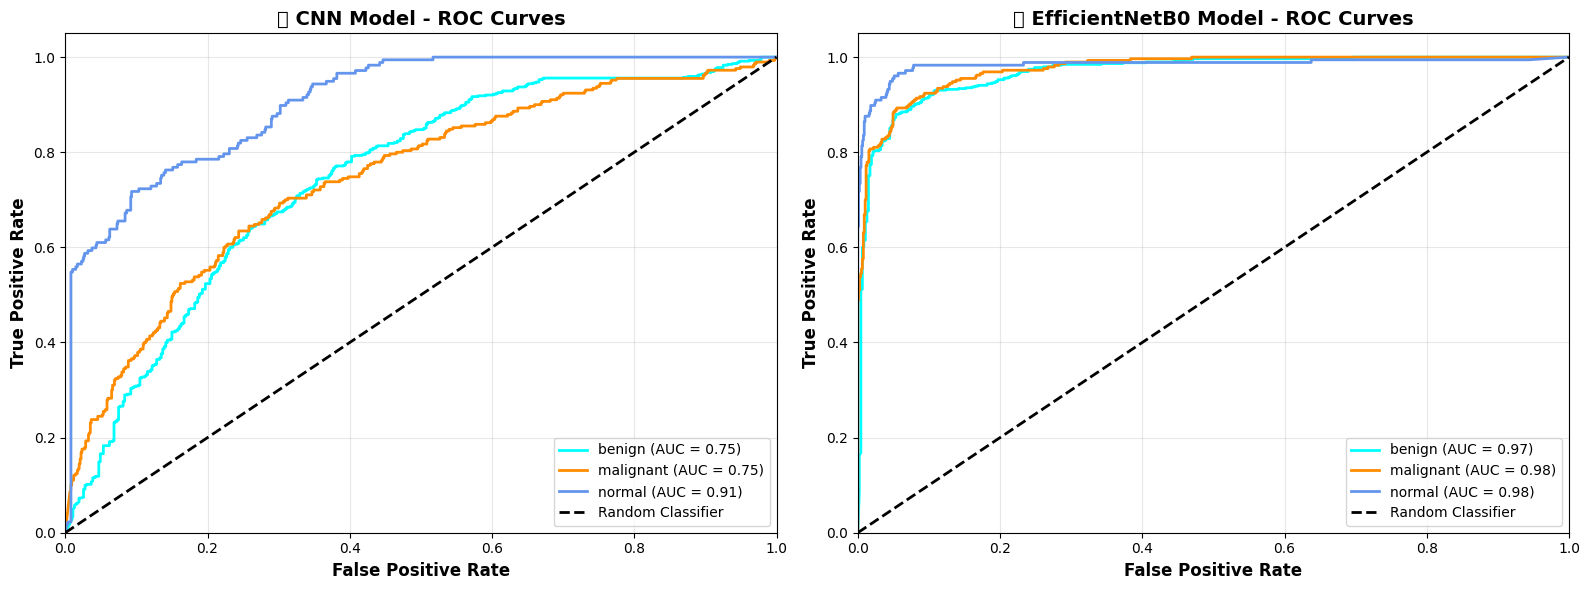


📊 AUC SCORE COMPARISON: CNN vs EfficientNetB0

BENIGN:
  CNN AUC:            0.7464
  EfficientNetB0 AUC: 0.9682
  Improvement:        +29.73%

MALIGNANT:
  CNN AUC:            0.7458
  EfficientNetB0 AUC: 0.9752
  Improvement:        +30.76%

NORMAL:
  CNN AUC:            0.9070
  EfficientNetB0 AUC: 0.9841
  Improvement:        +8.50%


Average AUC (CNN):            0.7997
Average AUC (EfficientNetB0): 0.9759
Overall Improvement:          +22.02%


In [41]:
#cell 17: ROC-AUC Curves - CNN vs EfficientNetB0
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ✅ Use stored or predefined class names
class_names = ['benign', 'malignant', 'normal']
n_classes = len(class_names)

# =========================================================
# 🔹 GET PREDICTIONS FOR BOTH MODELS
# =========================================================

# Extract true labels from test dataset
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
y_test_bin = label_binarize(y_test_true, classes=[0, 1, 2])

# CNN model predictions (probabilities)
y_score_cnn = model_cnn.predict(test_ds, verbose=0)

# EfficientNetB0 model predictions (probabilities)
y_score_eff = model_eff.predict(test_ds, verbose=0)

# =========================================================
# 🔹 COMPUTE ROC CURVE AND AUC FOR EACH CLASS
# =========================================================

# Initialize dictionaries to store values
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

fpr_eff = dict()
tpr_eff = dict()
roc_auc_eff = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    # CNN
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test_bin[:, i], y_score_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])
    
    # EfficientNetB0
    fpr_eff[i], tpr_eff[i], _ = roc_curve(y_test_bin[:, i], y_score_eff[:, i])
    roc_auc_eff[i] = auc(fpr_eff[i], tpr_eff[i])

# =========================================================
# 🔹 PLOT ROC CURVES - CNN vs EfficientNetB0
# =========================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

# Plot CNN ROC Curves
ax1 = axes[0]
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr_cnn[i], tpr_cnn[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc_cnn[i]:.2f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('🔵 CNN Model - ROC Curves', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=10)
ax1.grid(alpha=0.3)

# Plot EfficientNetB0 ROC Curves
ax2 = axes[1]
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr_eff[i], tpr_eff[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc_eff[i]:.2f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('🟢 EfficientNetB0 Model - ROC Curves', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =========================================================
# 🔹 PRINT AUC COMPARISON
# =========================================================

print("\n" + "="*60)
print("📊 AUC SCORE COMPARISON: CNN vs EfficientNetB0")
print("="*60)

for i, class_name in enumerate(class_names):
    print(f"\n{class_name.upper()}:")
    print(f"  CNN AUC:            {roc_auc_cnn[i]:.4f}")
    print(f"  EfficientNetB0 AUC: {roc_auc_eff[i]:.4f}")
    improvement = ((roc_auc_eff[i] - roc_auc_cnn[i]) / roc_auc_cnn[i]) * 100
    print(f"  Improvement:        {improvement:+.2f}%")

print("\n" + "="*60)
avg_auc_cnn = np.mean(list(roc_auc_cnn.values()))
avg_auc_eff = np.mean(list(roc_auc_eff.values()))
print(f"\nAverage AUC (CNN):            {avg_auc_cnn:.4f}")
print(f"Average AUC (EfficientNetB0): {avg_auc_eff:.4f}")
avg_improvement = ((avg_auc_eff - avg_auc_cnn) / avg_auc_cnn) * 100
print(f"Overall Improvement:          {avg_improvement:+.2f}%")
print("="*60)

---
# **Save, Load, and Use the Models**

In [42]:
#cell 18
# Save model:
model_cnn.save(r"C:\Users\archi\Desktop\projects\python\breast_cancer_cnn.keras")

# Load later:
loaded_model_cnn = tf.keras.models.load_model(r"C:\Users\archi\Desktop\projects\python\breast_cancer_cnn.keras")


C:\Users\archi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
#cell 19
# Save model:
model_eff.save(r"C:\Users\archi\Desktop\projects\python\breast_cancer_eff.keras")

# Load later:
loaded_model_eff = tf.keras.models.load_model(r"C:\Users\archi\Desktop\projects\python\breast_cancer_eff.keras")


| Phase | Step / Title | Purpose | Key Actions | Expected Outputs / Results |
|:------|:--------------|:---------|:-------------|:----------------------------|
| **1** | **Directory Setup** | Organize dataset and project structure | Create folders for images, dataset, etc. | Well-structured directory tree for project |
| **2** | **Dataset Organization** | Separate images by class | Folders: `benign`, `malignant`, `normal` | Label-wise categorized images |
| **3** | **Dataset Splitting** | Prepare training, validation, and testing sets | Split data into ~80% train, 10% val, 10% test | Independent sets for unbiased model training |
| **4** | **Data Preprocessing** | Standardize input images | Resize to `(224×224)`, normalize pixel values, batch loading | Clean, consistent dataset for CNN input |
| **5** | **CNN Model Building** | Design convolutional layers to extract image features | Use `Conv2D`, `MaxPooling`, `Flatten`, `Dense`, `Dropout` layers | CNN architecture summary and structure |
| **6** | **Model Compilation** | Set learning rules for model training | Define optimizer (`Adam`), loss (`categorical_crossentropy`), metrics (`accuracy`) | Model ready for training |
| **7** | **Model Training** | Train CNN on labeled ultrasound data | Fit model with `train_ds`, validate with `val_ds`, tune epochs | Training & validation accuracy/loss curves |
| **8** | **Model Evaluation** | Assess performance on unseen data | Evaluate using `test_ds`, generate confusion matrix & classification report | Accuracy, precision, recall, F1-score |
| **9** | **Visualization & Analysis** | Inspect model behavior and results | Plot accuracy/loss graphs, confusion matrix, prediction samples | Performance trends and diagnostic visuals |
| **10** | **Model Saving & Deployment** | Preserve trained model for reuse and prediction | Save as `.h5` file, load later for new predictions | Saved model + prediction function for new ultrasound scans |


---
# **UPDATE 2: EfficientNetB0 + SVM Hybrid Model**

In [61]:
# EfficientNet feature extractor (no classifier)
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'        # IMPORTANT: gives feature vector for SVM
)

base.trainable = False  # freeze

In [62]:

def extract_features(dataset, feature_extractor):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels.numpy())

    return np.concatenate(features), np.concatenate(labels)


In [63]:
X_train, y_train = extract_features(train_ds, base)
X_val, y_val     = extract_features(val_ds, base)
X_test, y_test   = extract_features(test_ds, base)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672

In [64]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [65]:
from sklearn.metrics import accuracy_score, classification_report

# Validation accuracy
y_val_pred = svm_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

# Test accuracy
y_test_pred = svm_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Validation Accuracy: 0.8835227272727273
Test Accuracy: 0.8684957426679281

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       590
           1       0.83      0.81      0.82       290
           2       0.85      0.83      0.84       177

    accuracy                           0.87      1057
   macro avg       0.86      0.85      0.85      1057
weighted avg       0.87      0.87      0.87      1057

